In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(
    style='ticks',
    font_scale=1.5
)
import sys
sys.path.append('../src')
import plots

In [29]:
import scipy.stats

In [ ]:
scipy.stats.rv

In [38]:
def simulation(N, n, η, ω, π0):
    """Run a single simulation.
    
    Parameters
    ----------
    N : int
        constant population size
    n : int
        number of generations
    η : float
        learning rate, 0 <= η <= 1    
    ω : numpy.ndarray
        fitness values for the two phenotyes: ω[t, i] >= 0 fitness of phenotype i at time t
    π0 : function
        function that given N, returns an initial value for π.    

    Returns
    -------
    π : np.ndarray
        π[t, i] is the probability for phenotype 0 in individual i at time t
    """        
    # π[t, i] is the probability for phenotype 0 atin individual i at time t
    π = np.zeros((n, N), dtype=float)
    π[0, :] = π0(N)
    π[0, π[0, :] < 0] = 0
    π[0, π[0, :] > 1] = 1
    π[1, :] = π[0, :] # for light simulations

    for t in range(n - 1):
        # phenotype of each individual
        φ = np.zeros(N, dtype=int)
        φ[np.random.random(N) > π[t, :]] = 1
        # fitness of each invidividual in current environment
        ω_t = ω[t, φ]
        assert (ω_t > 0).any(), "Population extinct, ω_t=0"
        ω_t = ω_t / ω_t.sum()
        # selection & reproduction; idx is the indexes of reproducing individuals
        idx = np.random.choice(N, N, True, ω_t)
        # offspring phenotype probability
        π_ = π[t, idx]
        π_ = (1 - η) * π_ + η * (φ[idx] == 0) # learning
        assert (π_ <= 1).all(), π_[π_ > 1]
        assert (π_ >= 0).all(), π_[π_ < 0]
        π[t + 1, :] = π_
    return π

In [104]:
N = 100000
n = 1000
η = 0.1
p = 0.499
s = 0.1

s = np.random.choice([s, -s], size=n, replace=True, p=[p, 1-p])
ωA = 1 + s 
ωB = np.ones(n)
print((ωA - ωB).mean(), np.log(1 + η * s).mean())
ω = np.array([ωA, ωB]).T

-0.001 -0.0001500058337


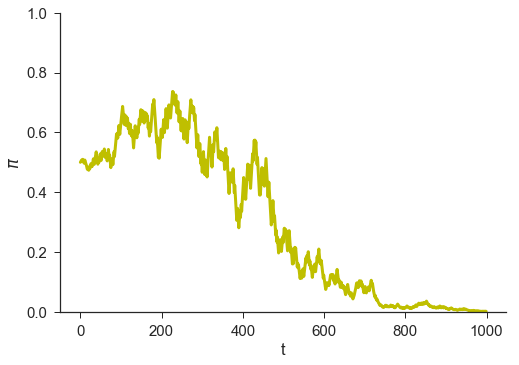

In [105]:
π = simulation(N, n, η, ω, lambda N: np.ones(N) * 0.5)
plots.plot_π(π, bands=0)

In [108]:
π[-1, :].mean()

(0.0014899999999999991, 0.0)

In [110]:
N = 100000
n = 1000
η = 0.1
p = 0.5
s = 0.1

reps = 100
results = []
for _ in range(reps):
    s_ = np.random.choice([s, -s], size=n, replace=True, p=[p, 1-p])
    ωA = 1 + s_ 
    ωB = np.ones(n)
    E = (ωA - ωB).mean()
    Elog =  np.log(1 + η * s_).mean()
    ω = np.array([ωA, ωB]).T
    π = simulation(N, n, η, ω, lambda N: np.ones(N) * 0.5)
    π_ = π[-1, :].mean()
    results.append(dict(π=π_, E=E, Elog=Elog, ))
df = pd.DataFrame(results)

In [148]:
df['E2'] = np.exp(df['Elog']-1)

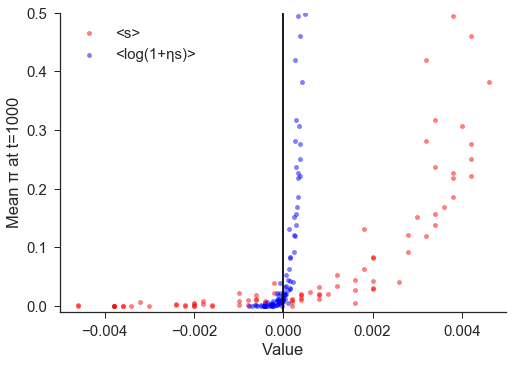

In [167]:
fig, ax = plt.subplots(1, 1)
df.plot('E', 'π', kind='scatter', color='r', alpha=0.5, label='<s>', ax=ax)
df.plot('Elog', 'π', kind='scatter', color='b', alpha=0.5, label='<log(1+ηs)>', ax=ax)
ax.axvline(0, color='k')
ax.legend(loc='upper left')
ax.set(
    xlabel='Value',
    ylabel='Mean π at t={}'.format(n),
    xlim=(-0.005, 0.005),
    ylim=(-0.01, 0.5)
)
sns.despine()